<a href="https://colab.research.google.com/github/JingyuanWu17/DL/blob/master/hw1prob4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
# ...
# ...
print(a)
print(b)

[[0.91250484 0.54499718 0.85184009]
 [0.00294971 0.27893965 0.51743166]]
tensor([[0.9125, 0.5450, 0.8518],
        [0.0029, 0.2789, 0.5174]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.6591],
        [1.0333]], grad_fn=<AddBackward0>)
tensor(1.6925, grad_fn=<SumBackward0>)
tensor([[0.3340],
        [0.3944]])
tensor([[0.0306],
        [0.4329]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let us examine the size of the dataset.

In [11]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?
# ...
# ...
print(trainingdata.data.size())
print(testdata.data.size())
image, label = trainingdata[0]
image.numel()

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


784

Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

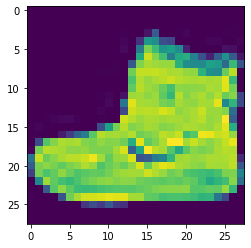

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.
# ...
# ...
plt.imshow(image.reshape(28,28))


Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [13]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([4, 6, 5, 5, 2, 8, 9, 9, 0, 7, 5, 0, 8, 2, 6, 7, 9, 4, 9, 4, 0, 5, 8, 9,
        5, 0, 5, 6, 6, 5, 1, 6, 4, 2, 3, 3, 5, 8, 4, 9, 8, 3, 9, 4, 9, 9, 0, 9,
        6, 2, 0, 4, 5, 5, 3, 2, 0, 1, 2, 1, 9, 7, 2, 8])


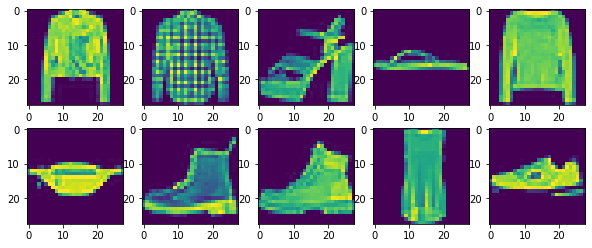

In [14]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.
# ...
# ...
plt.figure(figsize=(10,4))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i].cpu().reshape(28,28))

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Now we have set everything up. Let's try to train the network.

In [ ]:
train_loss_history = []
test_loss_history = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Q4.5 Write down a for-loop that trains this network for 20 epochs, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.
# ...
# ...
for epoch in range(20):

  batch_losses=[]
  for x_batch, y_batch in trainDataLoader:
    net.train()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # forward + backward + optimize
    yhat = net(x_batch)
    loss = Loss(yhat, y_batch)
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    batch_losses.append(loss)

  train_loss = torch.mean(torch.stack(batch_losses))
  train_loss_history.append(train_loss)

  test_losses=[]
  for x_test, y_test in testDataLoader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    yhat_loss = net(x_test)
    test_loss = Loss(yhat_loss, y_test)
    test_losses.append(test_loss)
    
  test_loss = torch.mean(torch.stack(test_losses))
  test_loss_history.append(test_loss)


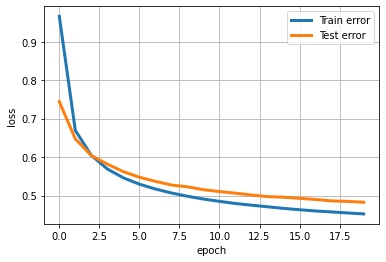

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [ ]:
images = images.to(device)
labels = labels.to(device)
predicted_output = net(images)
max = torch.max(predicted_output, 1)
print(torch.max(predicted_output, 1))

In [ ]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  # ...
  # ...
  correct = 0
  total = 0
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    yhat = net(x_batch)
    _, predicted = torch.max(yhat, 1)
    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()
    
  return correct / total

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 0.85, test acc = 0.83
